In [1]:
import pandas as pd
import numpy as np
import os
# Keep using Keras 2
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow_decision_forests as tfdf
import tensorflow as tf
import tf_keras
import math
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.inspection import partial_dependence, permutation_importance
# from sklearn.metrics import r2_score
# from sklearn.preprocessing import OneHotEncoder
# from scipy import stats
# import matplotlib.pyplot as plt
# from statsmodels.nonparametric.smoothers_lowess import lowess
# import seaborn as sns
# from tqdm import tqdm

In [2]:

data = pd.read_csv('data.csv', index_col="Coden")
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

In [95]:
# 数据分割函数
def prepare_data(df, crop_type: str, target_col='Yield'):
    if crop_type != 'threecrops':
        filtered = df[df['Crop.type'] == crop_type]
        cols = {
            'Maize': ["Yield", "Slope", "Irrigation", "Cropping.system.in.the.site", 
                     "Rotational.systems", "Name.of.previous.crop", "Growing.days", 
                     "GDD", "Tmax", "Tmin", "PRE", "RAD", "Soil.type", "SOC", "OP", 
                     "AK", "PH", "PK.fert", "N.fert", "SAND", "SILT", "CLAY", 
                     "AWC", "Bulk.density", "Crop.variety", "AI", "PET10"],
            'Wheat': ["Yield", "Slope", "Irrigation", "Cropping.system.in.the.site",
                     "Rotational.systems", "Name.of.previous.crop", "Growing.days",
                     "GDD", "Tmax", "Tmin", "PRE", "RAD", "Soil.type", "SOC", "OP",
                     "AK", "PH", "PK.fert", "N.fert", "SAND", "SILT", "CLAY",
                     "AWC", "Bulk.density", "Crop.variety", "AI", "PET10"],
            'Rice': ["Yield", "Slope", "Cropping.system.in.the.site", 
                    "Rotational.systems", "Growing.days", "GDD", "Tmax", "Tmin", 
                    "PRE", "RAD", "Soil.type", "SOC", "OP", "AK", "PH", "PK.fert", 
                    "N.fert", "SAND", "SILT", "CLAY", "AWC", "Bulk.density", 
                    "Crop.variety", "AI", "PET10"]
        }
        return filtered[cols[crop_type]]
    else:
        cols = ["Yield.normalized", "Slope", "Irrigation", "Cropping.system.in.the.site",
               "Rotational.systems", "Name.of.previous.crop", "Growing.days", "GDD",
               "Tmax", "Tmin", "PRE", "RAD", "Soil.type", "SOC", "OP", "AK", "PH",
               "PK.fert", "N.fert", "SAND", "SILT", "CLAY", "AWC", "Bulk.density",
               "Crop.variety", "AI", "PET10"]
        return df[cols]

# 准备数据
Maize = prepare_data(data, 'Maize')
Wheat = prepare_data(data, 'Wheat')
Rice = prepare_data(data, 'Rice')
threecrops = prepare_data(data, 'threecrops')


In [96]:
Maize.head(3)

,Yield,Slope,Irrigation,Cropping.system.in.the.site,Rotational.systems,Name.of.previous.crop,Growing.days,GDD,Tmax,Tmin,...,PK.fert,N.fert,SAND,SILT,CLAY,AWC,Bulk.density,Crop.variety,AI,PET10
Coden,,,,,,,,,,,,,,,,,,,,,
1,9005,2.0,No,2 times a year,Maize-wheat,Wheat,119,475.0,19.43,10.56,...,1,1.0,34,41,25,0.147,1.36,Medium-maturing variety,0.983475,951.74
2,9839,2.0,No,2 times a year,Maize-wheat,Wheat,119,475.0,19.43,10.56,...,1,1.5,34,41,25,0.147,1.36,Medium-maturing variety,0.983475,951.74
3,9394,2.0,No,2 times a year,Maize-wheat,Wheat,119,475.0,19.43,10.56,...,1,0.5,34,41,25,0.147,1.36,Medium-maturing variety,0.983475,951.74


In [97]:
Maize.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24107 entries, 1 to 24107
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Yield                        24107 non-null  int64  
 1   Slope                        24107 non-null  float64
 2   Irrigation                   24107 non-null  object 
 3   Cropping.system.in.the.site  24092 non-null  object 
 4   Rotational.systems           23662 non-null  object 
 5   Name.of.previous.crop        23590 non-null  object 
 6   Growing.days                 24107 non-null  int64  
 7   GDD                          24107 non-null  float64
 8   Tmax                         24107 non-null  float64
 9   Tmin                         24107 non-null  float64
 10  PRE                          24107 non-null  float64
 11  RAD                          24107 non-null  float64
 12  Soil.type                    24107 non-null  object 
 13  SOC                  

In [98]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(Maize)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

16806 examples in training, 7301 examples for testing.


In [99]:
Maize.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24107 entries, 1 to 24107
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Yield                        24107 non-null  int64  
 1   Slope                        24107 non-null  float64
 2   Irrigation                   24107 non-null  object 
 3   Cropping.system.in.the.site  24092 non-null  object 
 4   Rotational.systems           23662 non-null  object 
 5   Name.of.previous.crop        23590 non-null  object 
 6   Growing.days                 24107 non-null  int64  
 7   GDD                          24107 non-null  float64
 8   Tmax                         24107 non-null  float64
 9   Tmin                         24107 non-null  float64
 10  PRE                          24107 non-null  float64
 11  RAD                          24107 non-null  float64
 12  Soil.type                    24107 non-null  object 
 13  SOC                  

In [100]:
label = 'Yield'

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

In [101]:
# Specify the model.
rf_model = tfdf.keras.RandomForestModel(verbose=2,
                                        hyperparameter_template="benchmark_rank1",
                                         num_trees=500, 
                                         task=tfdf.keras.Task.REGRESSION,
                                         compute_oob_performances=True,
                                         compute_oob_variable_importances=True,
                                         random_seed=123,
                                         )

# Train the model.
rf_model.fit(train_ds)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use 10 thread(s) for training
Use /var/folders/11/31lkrfvs65ddtbwvncf1q57m0000gn/T/tmpbhg193vu as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'Slope': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'Irrigation': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'Cropping.system.in.the.site': <tf.Tensor 'data_2:0' shape=(None,) dtype=string>, 'Rotational.systems': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'Name.of.previous.crop': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>, 'Growing.days': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, 'GDD': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'Tmax': <tf.Tensor 'data_7:0' shape=(None,) dtype=float64>, 'Tmin

In [102]:
# Evaluate the model on the test dataset.
rf_model.compile(metrics=["mse"])
evaluation = rf_model.evaluate(test_ds, return_dict=True)

print(evaluation)
print()
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")



8/8 [==============================] - 1s 101ms/step - loss: 0.0000e+00 - mse: 1659792.3750
{'loss': 0.0, 'mse': 1659792.375}

loss: 0.0000
mse: 1659792.3750


In [103]:
tfdf.model_plotter.plot_model_in_colab(rf_model, tree_idx=0, max_depth=3)

In [104]:
rf_model.summary()

Model: "random_forest_model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (26):
	AI
	AK
	AWC
	Bulk.density
	CLAY
	Crop.variety
	Cropping.system.in.the.site
	GDD
	Growing.days
	Irrigation
	N.fert
	Name.of.previous.crop
	OP
	PET10
	PH
	PK.fert
	PRE
	RAD
	Rotational.systems
	SAND
	SILT
	SOC
	Slope
	Soil.type
	Tmax
	Tmin

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.                      "N.fert"  0.569374 ################
    2.                     "PK.fert"  0.237931 #####
    3.                          "AI"  0.236368 #####
    4.                        "Tmin"  0.193807 ###
    5.                         "RAD"  0.144953 ##
    6.                         "P

In [105]:
rf_model.make_inspector().variable_importances()

{'NUM_AS_ROOT': [("N.fert" (1; #10), 352.0),
  ("PK.fert" (1; #15), 168.0),
  ("AI" (1; #0), 45.0),
  ("Tmax" (1; #24), 45.0),
  ("GDD" (1; #7), 40.0),
  ("Slope" (1; #22), 40.0),
  ("Tmin" (1; #25), 39.0),
  ("RAD" (1; #17), 36.0),
  ("AK" (1; #1), 33.0),
  ("SOC" (1; #21), 33.0),
  ("Bulk.density" (1; #3), 32.0),
  ("SAND" (1; #19), 28.0),
  ("PRE" (1; #16), 26.0),
  ("Growing.days" (1; #8), 25.0),
  ("PET10" (1; #13), 25.0),
  ("OP" (1; #12), 24.0),
  ("PH" (1; #14), 23.0),
  ("CLAY" (1; #4), 18.0),
  ("SILT" (1; #20), 15.0),
  ("AWC" (1; #2), 13.0)],
 'SUM_SCORE': [("N.fert" (1; #10), 9600509183848.371),
  ("PK.fert" (1; #15), 5317993769416.957),
  ("AI" (1; #0), 4923562606678.471),
  ("Tmin" (1; #25), 4665737729851.178),
  ("PRE" (1; #16), 3670007441013.0674),
  ("RAD" (1; #17), 3550493635489.399),
  ("GDD" (1; #7), 3272468817133.5654),
  ("Tmax" (1; #24), 3188024958074.174),
  ("PET10" (1; #13), 2979632052393.273),
  ("SOC" (1; #21), 2889223887355.1426),
  ("Slope" (1; #22), 2754

In [106]:
rf_model.make_inspector().evaluation()

Evaluation(num_examples=16806, accuracy=None, loss=None, rmse=1301.0175283130898, ndcg=None, aucs=None, auuc=None, qini=None)

In [107]:
rf_model.make_inspector().training_logs()

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=6228, accuracy=None, loss=None, rmse=1791.8177041584188, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=16710, accuracy=None, loss=None, rmse=1447.2657900599188, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=16804, accuracy=None, loss=None, rmse=1365.2485307480829, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=16806, accuracy=None, loss=None, rmse=1343.4981243717602, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=16806, accuracy=None, loss=None, rmse=1330.2986490982457, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=16806, accuracy=None, loss=None, rmse=1323.6342677746943, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=61, 

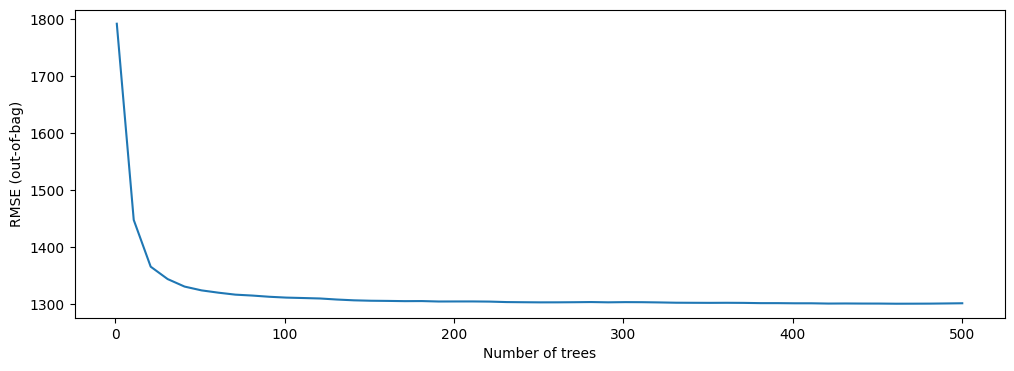

In [108]:
import matplotlib.pyplot as plt

logs = rf_model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")

plt.show()

In [109]:
tfdf.keras.RandomForestModel?

Init signature: tfdf.keras.RandomForestModel(*args, **kwargs)
Docstring:     
Random Forest learning algorithm.

A [Random Forest](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)
is a collection of deep CART decision trees trained independently and without
pruning. Each tree is trained on a random subset of the original training 
dataset (sampled with replacement).

The algorithm is unique in that it is robust to overfitting, even in extreme
cases e.g. when there are more features than training examples.

It is probably the most well-known of the Decision Forest training
algorithms.

Usage example:

```python
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Hyper-parameter tuning:

```python
import tensorflow_decision_forests as tfdf
import pandas 

In [110]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.inspection import partial_dependence, permutation_importance, plot_partial_dependence
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/opt/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/sklearn/inspection/__init__.py)

In [ ]:
print(rf_model)

In [ ]:
def reg_smooth(x, y, lambda_=0.01):
    return lowess(y, x, frac=lambda_, return_sorted=False)

# 定义bootstrap预测函数
def pred_wrapper_boot(model, X, grid_points, n_boot=100):
    preds = []
    for point in grid_points:
        X_temp = X.copy()
        X_temp['SOC'] = point
        pred = [model.predict(X_temp.sample(n=len(X_temp), replace=True)) 
                for _ in range(n_boot)]
        preds.append(np.mean(pred))
    return np.array(preds)

# 定义阈值计算函数
def get_threshold(model, X, grid_resolution=51, window_size=10):
    grid = np.linspace(X['SOC'].min(), X['SOC'].max(), grid_resolution)

    lower = data['SOC'].min() / (data['SOC'].min() + data['SOC'].max())
    upper = data['SOC'].max() / (data['SOC'].min() + data['SOC'].max())
    pd_values = partial_dependence(model, X, ['SOC'], percentiles=(0, 1), grid_resolution=grid_resolution)
    pd_smooth = lowess(pd_values['average'][0], grid, frac=0.01, return_sorted=False)
    
    # 计算斜率显著性（修复索引和窗口逻辑）
    slopes = np.diff(pd_smooth) / np.diff(grid)
    n_slopes = len(slopes)
    p_values = []
    
    # 使用滑动窗口处理斜率显著性
    for i in range(n_slopes - window_size + 1):
        sample = slopes[i:i + window_size]
        t_stat, p_val = stats.ttest_1samp(sample, 0)
        p_values.append(p_val)
    
    # 处理无显著差异的情况
    if not p_values:
        threshold_idx = 0
    else:
        significant_points = np.where(np.array(p_values) > 0.05)[0]
        if len(significant_points) == 0:
            threshold_idx = 0
        else:
            threshold_idx = significant_points[0] + window_size // 2
    
    # 映射回原始grid索引（grid比slopes多1个点）
    soc_threshold = grid[threshold_idx + 1] if (threshold_idx + 1) < len(grid) else grid[-1]
    yield_threshold = pd_smooth[threshold_idx + 1] if (threshold_idx + 1) < len(pd_smooth) else pd_smooth[-1]
    
    return soc_threshold, yield_threshold

# 通用建模函数
def build_model(data, target_col='Yield', n_estimators=500, max_features=5):
    X = data.drop(columns=[target_col])
    y = data[target_col]
    
    model = RandomForestRegressor(n_estimators=n_estimators,
                                max_features=max_features,
                                oob_score=True,
                                random_state=123)
    model.fit(X, y)
    
    # 变量重要性
    imp = permutation_importance(model, X, y, n_repeats=10)
    sorted_idx = imp.importances_mean.argsort()[::-1]
    
    # 预测和评估
    pred = model.predict(X)
    r2 = r2_score(y, pred)
    oob = model.oob_score_
    
    return model, imp, sorted_idx, r2, oob

# 分析函数
def analyze_crop(model, data_tf: tf.data.Dataset, data: pd.DataFrame, crop_name: str, target_col: str = 'Yield'):
    
    model.fit(data_tf)
    # 计算部分依赖
    grid = np.linspace(data['SOC'].min(), data['SOC'].max(), 51)

    # 参数变化： grid_points -> percentiles
    # pd_values = partial_dependence(model, X, ['SOC'], percentiles=(lower, upper), grid_resolution=51)
    pd_values = partial_dependence(model, data, ['SOC'], percentiles=(0, 1), grid_resolution=51, kind='both')
    pd_smooth = lowess(pd_values['average'][0], grid, frac=0.01, return_sorted=False)
    
    pd_individual = pd_values['individual'][0]
    pd_mean = pd_individual.mean(axis=0)
    pd_std = pd_individual.std(axis=0, ddof=1)
    ci_low = pd_mean - 1.96 * pd_std
    ci_high = pd_mean + 1.96 * pd_std

    # Bootstrap置信区间
    boot_results = []
    for _ in tqdm(range(100)):  # 可根据计算资源调整次数
        sample = data.sample(n=len(data), replace=True)
        sample_tfdf = tfdf.keras.pd_dataframe_to_tf_dataset(sample, label=target_col)
        model_boot = model.fit(sample_tfdf)
        threshold = get_threshold(model_boot, sample.drop(columns=[target_col]))
        boot_results.append(threshold)
    
    # 统计结果
    soc_values = [x[0] for x in boot_results]
    yield_values = [x[1] for x in boot_results]
    
    # 绘制结果
    plt.figure(figsize=(10,6))
    plt.plot(grid, pd_smooth, 'b-', lw=2, label='Partial Dependence')
    plt.fill_between(grid,
                    ci_low,
                    ci_high,
                    alpha=0.2, color='blue')
    plt.axvline(x=np.mean(soc_values), color='red', linestyle='--', 
                label=f'Threshold: {np.mean(soc_values):.1f} g/kg')
    plt.xlabel('Soil Organic Carbon (g/kg)')
    plt.ylabel('Predicted Yield (kg/ha)')
    plt.title(f'{crop_name} Yield Response to SOC')
    plt.legend()
    plt.show()
    
    return {
        'soc_threshold': (np.mean(soc_values)), 
        'yield_gap': (np.mean(yield_values)),
        'confidence_interval': stats.t.interval(0.95, len(soc_values)-1,
                                              loc=np.mean(soc_values),
                                              scale=stats.sem(soc_values))
    }


In [ ]:
maize_results = analyze_crop(rf_model, data_tf=train_ds, data=train_ds_pd, crop_name='Maize', target_col='Yield')# 输出结果
print("Maize SOC threshold:", maize_results['soc_threshold'])

Reading training dataset...
Training dataset read in 0:00:00.092935. Found 16819 examples.
Training model...
Model trained in 0:00:31.278391
Compiling model...
Model compiled.


NotFittedError: This RandomForestModel instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

100%|██████████| 10/10 [01:55<00:00, 11.53s/it]


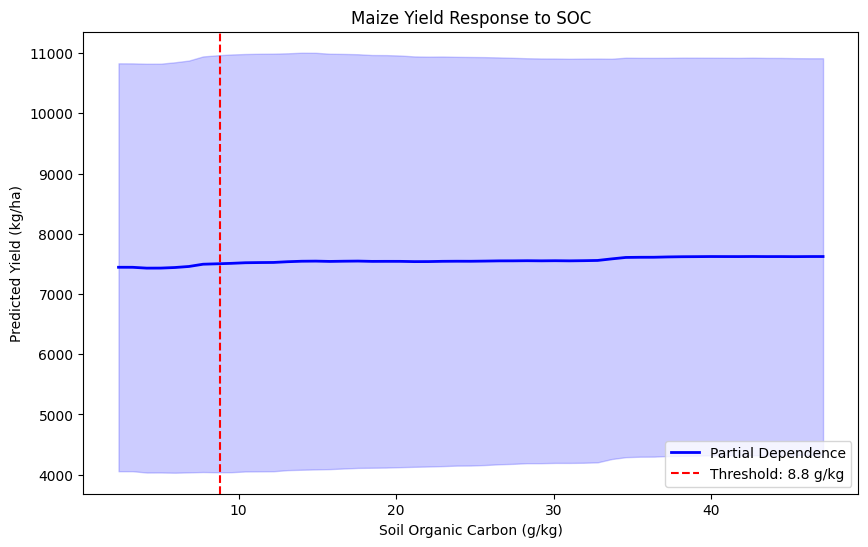

100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


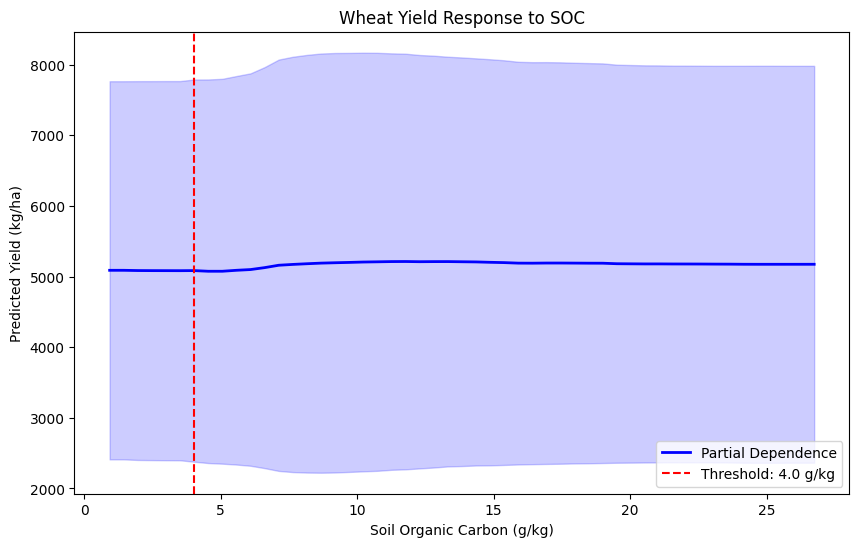

/opt/anaconda3/envs/scienv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/anaconda3/envs/scienv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
100%|██████████| 10/10 [01:37<00:00,  9.79s/it]


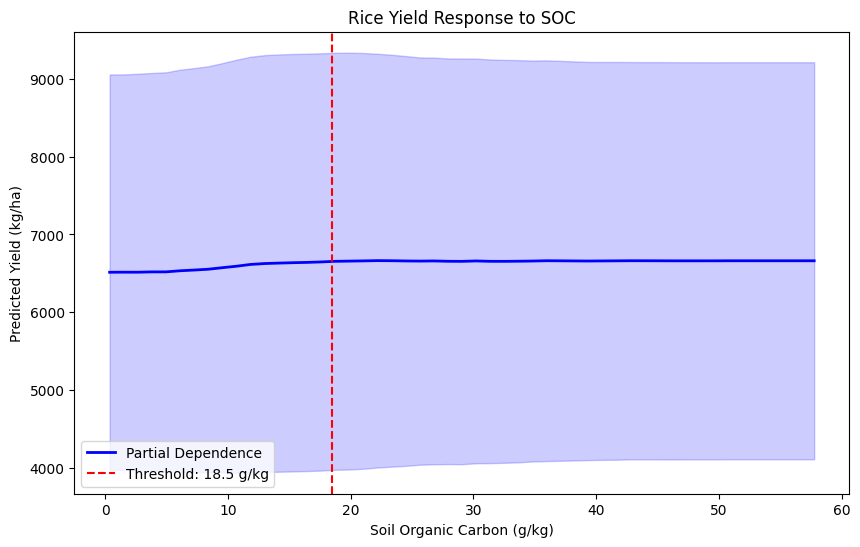

KeyboardInterrupt: 

In [ ]:
# 执行分析
maize_results = analyze_crop(Maize, crop_name='Maize', target_col='Yield')
wheat_results = analyze_crop(Wheat, crop_name='Wheat', target_col='Yield')
rice_results = analyze_crop(Rice, crop_name='Rice', target_col='Yield')
threecrops_results = analyze_crop(threecrops, crop_name='Three Crops', target_col='Yield.normalized')

# 输出结果
print("Maize SOC threshold:", maize_results['soc_threshold'])
print("Wheat SOC threshold:", wheat_results['soc_threshold'])
print("Rice SOC threshold:", rice_results['soc_threshold'])
print("Three Crops threshold:", threecrops_results['soc_threshold'])

In [ ]:
import os
# Keep using Keras 2
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import tensorflow_decision_forests as tfdf
import tensorflow as tf
import tf_keras
import math

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

In [ ]:
# Download the dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("/tmp/penguins.csv")

# Display the first 3 examples.
dataset_df.head(3)